November 21, 2025

This is my first attempt at creating a custom CV model using torch. To simplify the problem, I will be only using 369 2D images (the middle slices of each MRI patient) from one modality (t1ce - tumors show up well) to identify one tumor structure (whole tumor). 

# The Data Pipeline: 3D .nii file -> 2d image -> torch tensors

In [ ]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

DATA_ROOT = Path("/Users/michaelbanks/Desktop/AI TXG/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")

class BraTSDataset(Dataset):
    def __init__(self, root_dir, slice_idx=75):

        self.root_dir = Path(root_dir)
        self.slice_idx = slice_idx
            
        self.patient_folders = list(DATA_ROOT.glob("BraTS20_Training_*"))
        
        if len(self.patient_folders) == 0:
            print(f"WARNING: No patient folders found in {self.root_dir}")
        else:
            print(f"Success! Found {len(self.patient_folders)} patients in {self.root_dir.name}")

    def __len__(self):
        return len(self.patient_folders)

    def __getitem__(self, index):
        patient_path = self.patient_folders[index]
        patient_id = patient_path.name 
        
        img_path = patient_path / f"{patient_id}_t1ce.nii"
        mask_path = patient_path / f"{patient_id}_seg.nii"
        
        img_3d = nib.load(img_path).get_fdata() 
        mask_3d = nib.load(mask_path).get_fdata()
        
        img_slice = img_3d[:, :, self.slice_idx]
        mask_slice = mask_3d[:, :, self.slice_idx]
        
        if img_slice.max() > 0:
            img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
        
        mask_slice[mask_slice > 0] = 1.0 
        
        img_tensor = torch.from_numpy(img_slice).float().unsqueeze(0)
        mask_tensor = torch.from_numpy(mask_slice).float().unsqueeze(0)
        
        return img_tensor, mask_tensor

##### Quick Data Visualization

Success! Found 369 patients in MICCAI_BraTS2020_TrainingData
Image Shape: torch.Size([1, 240, 240])
Mask Shape: torch.Size([1, 240, 240])


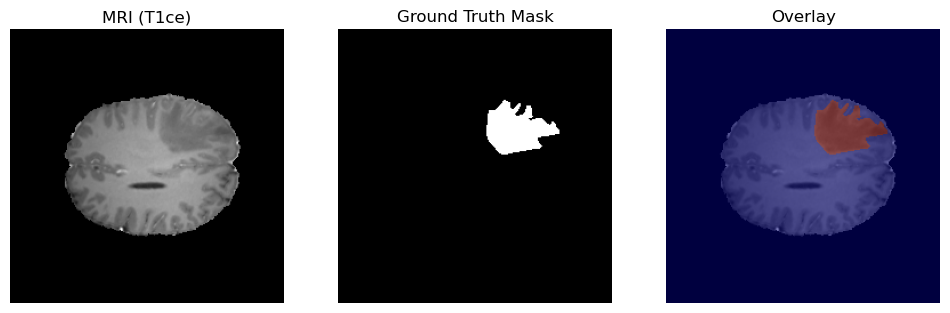

In [ ]:
dataset = BraTSDataset(DATA_ROOT, slice_idx=100)

if len(dataset) > 0:
    sample_img, sample_mask = dataset[1] 

    print(f"Image Shape: {sample_img.shape}") 
    print(f"Mask Shape: {sample_mask.shape}")

    def visualize_overlay(img_tensor, mask_tensor):
        img = img_tensor.squeeze().numpy()
        mask = mask_tensor.squeeze().numpy()
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title("MRI (T1ce)")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(img, cmap='gray')
        plt.imshow(mask, cmap='jet', alpha=0.5) 
        plt.title("Overlay")
        plt.axis('off')
        
        plt.show()

    visualize_overlay(sample_img, sample_mask)
else:
    print("ERROR: Dataset is empty. Please check the path printed above.")

##### The DataLoader

In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

batch_imgs, batch_masks = next(iter(dataloader))

print(f"Batch of Images Shape: {batch_imgs.shape}") 
print(f"Batch of Masks Shape:  {batch_masks.shape}")
# Expected: (16, 1, 240, 240) -> (Batch, Channel, Height, Width)

Batch of Images Shape: torch.Size([16, 1, 240, 240])
Batch of Masks Shape:  torch.Size([16, 1, 240, 240])


# The Model: U-NET

In [ ]:
import torch.nn as nn

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.enc1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.Conv2d(16, 16, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2, 2) # 240 -> 120
        
        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.Conv2d(32, 32, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2, 2) # 120 -> 60
        
        self.enc3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool3 = nn.MaxPool2d(2, 2) # 60 -> 30

        self.bottleneck = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) 
        self.dec3 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU()) 

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) 
        self.dec2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU()) 

        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2) 
        self.dec1 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU()) 

        self.final = nn.Conv2d(16, 1, kernel_size=1) 
        self.sigmoid = nn.Sigmoid() 

    def forward(self, x):

        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        
        b = self.bottleneck(self.pool3(e3))
        
        d3 = self.up3(b)
        d3 = torch.cat((e3, d3), dim=1) 
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat((e2, d2), dim=1) 
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((e1, d1), dim=1) 
        d1 = self.dec1(d1)
        
        return self.sigmoid(self.final(d1))

##### Quick Shape Check

In [ ]:
model = SimpleUNet()

predictions = model(batch_imgs).detach()

print(f"Input Shape:      {batch_imgs.shape}")
print(f"Prediction Shape: {predictions.shape}")

assert predictions.shape == batch_masks.shape
print("SUCCESS: The model output matches the mask shape. Ready to train!")

Input Shape:      torch.Size([16, 1, 240, 240])
Prediction Shape: torch.Size([16, 1, 240, 240])
SUCCESS: The model output matches the mask shape. Ready to train!


##### Set up Device, Loss, and Optimizer

In [ ]:
import torch.optim as optim

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Success: Using Apple Metal (MPS) Acceleration!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Success: Using NVIDIA (CUDA) Acceleration!")
else:
    device = torch.device("cpu")
    print("Using CPU (Slower, but works)")

model = model.to(device)

criterion = torch.nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

Success: Using Apple Metal (MPS) Acceleration!


# The Training Loop

In [14]:
num_epochs = 10
history = [] 

print("Starting Training...")

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    
    for i, (images, masks) in enumerate(dataloader):
        
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()             
        
        outputs = model(images)           
        loss = criterion(outputs, masks)  
        
        loss.backward()                   
        optimizer.step()                  
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader)
    history.append(epoch_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training Finished!")

Starting Training...
Epoch [1/10], Loss: 0.1346
Epoch [2/10], Loss: 0.0964
Epoch [3/10], Loss: 0.0808
Epoch [4/10], Loss: 0.0792
Epoch [5/10], Loss: 0.0780
Epoch [6/10], Loss: 0.0792
Epoch [7/10], Loss: 0.0751
Epoch [8/10], Loss: 0.0723
Epoch [9/10], Loss: 0.0769
Epoch [10/10], Loss: 0.0741
Training Finished!


# Validation & Visualization

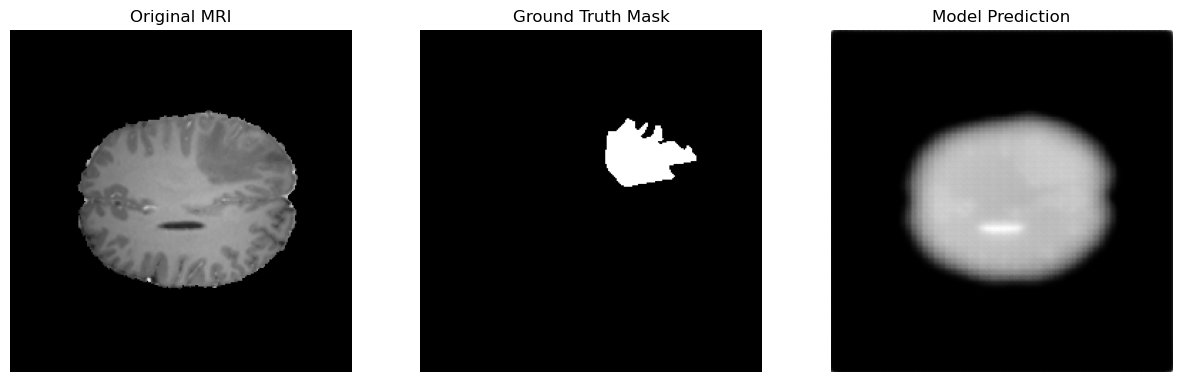

In [15]:
model.eval()

test_img, test_mask = dataset[1] 

input_tensor = test_img.unsqueeze(0).to(device)

with torch.no_grad(): 
    prediction = model(input_tensor)

pred_cpu = prediction.squeeze().cpu().numpy()
img_cpu = test_img.squeeze().numpy()
mask_cpu = test_mask.squeeze().numpy()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_cpu, cmap='gray')
plt.title("Original MRI")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_cpu, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_cpu, cmap='gray')
plt.title("Model Prediction")
plt.axis('off')

plt.show()

As expected, this model is not very good. It basically knows that there will not be a tumor on the black squares, so it predicts those correctly, but it has no idea where the actual tumor is in the brain, so it just guesses the whole thing with low confidence. Our relativeley low loss is misleading, this model is very bad (as expected - this model was trained on only 369 images and there is tons of room for improvement in the model architecture and training process). Cheers and I will see you in Model2.